In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 05
## Working with PyTorch - Flowers DataSet

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# By Pramod Sharma : pramod.sharma@prasami.com

###-----------------
### Import Libraries
###-----------------

import os
import datetime
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# from utils.log_event import fn_log_event


# verify if the directory exists
def fn_dir_exists(_dir):
    '''
    Args:
    	_dir: path if a directory
     '''

    res = os.path.exists(_dir)

    fn_log_event ('-- Directory "{}" exist : {}'.format(_dir, res), 'debug')

    if not res:

        fn_log_event ('-- Directory "{}" does not exists.'.format(_dir), 'debug')

        sys.exit('-- Directory "{}" does not exists.'.format(_dir))

    return res



def fn_file_exists(_file):
    '''
        verify if the file exists
    '''
    res = os.path.exists(_file)

    fn_log_event ('-- File "{}" exist : {}'.format(_file, res), 'debug')

    if not res:

        fn_log_event ('-- File "{}" does not exists.'.format(_file), 'debug')

        sys.exit('-- File "{}" does not exists.'.format(_file))

    return res


###-----------------------------
### Verify or create a directory
###-----------------------------
def fn_verify_dir(_path : str):
    '''
    Arg:
        path: path to verify the directory
    returns:
        create dir if it does not exists
    '''
    if os.path.exists(_path): # check if the path exists. Maybe a file or a folder

        print(_path, ' exists') # advised the user

    else:

        os.makedirs(_path) # create the path

        print("Created folder : ", _path)

###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]

    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')

    plt.tight_layout()



###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')

    plt.tight_layout()



###---------------------------------------------------
### Plot count of classes in training and testing sets
###---------------------------------------------------
def fn_plot_labels(tr_ds, ts_ds, class_names = None):

    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure and axes
    fig, axes = plt.subplots(1,2, figsize = (15,5))

    # get names of the classes
    if not class_names:
        tr_class_names = tr_ds.class_names
        ts_class_names = tr_ds.class_names

    # pick first axis
    ax = axes[0]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in tr_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1

    # bar plot
    ax.bar(tr_class_names, [class_counts.get(i, 0) for i in range(len(tr_class_names))],
           align='center',color = 'DarkBlue', alpha = 0.7)

    # add title
    ax.set_title('Training Set')

    # grids make it look good
    ax.grid()


    #pick second image
    ax = axes[1]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in ts_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1

    # bar plot
    ax.bar(ts_class_names, [class_counts.get(i, 0) for i in range(len(ts_class_names))],
           align='center',color = 'orange', alpha = 0.7)

    # add title
    ax.set_title('Test Set')


    # grids make it look good
    ax.grid()

    # fit the subplot(s) in to the figure area
    plt.tight_layout()

    # display all open figures
    plt.show()

def fn_convert_timestamp(tstr):
    '''
        Function to conver string of form "2015-11-12 1444"
    '''

    return datetime.strptime(tstr, "%Y-%m-%d_%H%M")

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())

    fig, ax = plt.subplots(figsize = (6,6))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


In [3]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import random

# from collections.abc import Callable
# from typing import Literal


# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import v2

# from utils.helper import fn_plot_torch_hist

In [4]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'flower_photos_torch'
altName = 'torch_all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 2001 # number of epochs

BATCH_SIZE = 16

TRAIN_SIZE = int(184 * BATCH_SIZE) # 000 <-- Pay Attention when changing BATCH_SIZE

ALPHA = 0.001 # learning rate

TEST_SIZE = 0.2

# Input Image size
IMG_HEIGHT = 186
IMG_WIDTH = 186

# for early stopping
PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 4),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [5]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

Created ../output directory
Created ./models/flower_photos_torch directory


## All about CUDA

In [6]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.1
Current Device ID:  0
Name of the CUDA device:  Tesla T4


In [7]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [8]:

# Define the dataset URL
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Define the directory to save the data
data_dir = "/content"

# Download the dataset
torch.hub.download_url_to_file(dataset_url, f"{data_dir}.tgz")

# Extract the data
import tarfile
with tarfile.open(f"{data_dir}.tgz", "r:gz") as tar:
    tar.extractall(path=data_dir)

100%|██████████| 218M/218M [00:03<00:00, 66.5MB/s]


In [9]:
torch.__version__

'2.3.0+cu121'

In [10]:
import torchvision
torchvision.__version__

'0.18.0+cu121'

## Read Flowers data set

In [46]:
###---------------
### Transformation
###---------------

transform = v2.Compose([
    v2.Resize(IMG_HEIGHT),
    v2.RandomRotation(degrees = (-45, 45)),
    v2.CenterCrop(IMG_HEIGHT),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_dir = os.path.join('/content/flower_photos')

train_dataset = datasets.ImageFolder(data_dir, transform=transform)

test_dataset = datasets.ImageFolder(data_dir, transform=transform)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
image, label = next(iter(train_dataset))
image.shape, label

(torch.Size([3, 186, 186]), 0)

In [45]:
dataset_size = len(train_dataset)

test_size = int(TEST_SIZE*dataset_size) # 22*32

train_size = dataset_size - test_size
print (dataset_size, train_size, test_size)

2944 2356 588


In [47]:
indices = torch.randperm(len(train_dataset)).tolist()
#indices

# pick up indices up to test_size
train_dataset = torch.utils.data.Subset(train_dataset,indices[:TRAIN_SIZE])

# pickup from test_size
test_dataset = torch.utils.data.Subset(test_dataset,indices[TRAIN_SIZE:])

len(train_dataset), len(test_dataset)

(2944, 726)

In [16]:
class_names = {count: nClass for count, nClass in enumerate(train_dataset.dataset.classes)}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [17]:
numClasses = len(class_names)
numClasses

5

In [18]:
next(iter(train_dataset))[0].shape

torch.Size([3, 186, 186])

## Data Loader

In [19]:
#torch.utils.data.DataLoader?

In [20]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)


trainSteps = len(train_dataloader.dataset) // BATCH_SIZE

testSteps = len(test_dataloader.dataset) // BATCH_SIZE

print (trainSteps, testSteps)

184 45


In [21]:
def fn_showImages(img, ax):

    img = img.numpy().transpose((1,2,0)) # change to channel last

    means = np.array([0.485, 0.456, 0.406]) # mean as per transform

    stds = np.array([0.229, 0.224, 0.225]) # std as per transforms

    img = stds * img + means # undo normalization

    img = np.clip(img, 0, 1) # clip values between [0,1]

    ax.imshow(img)
    ax.axis('off')

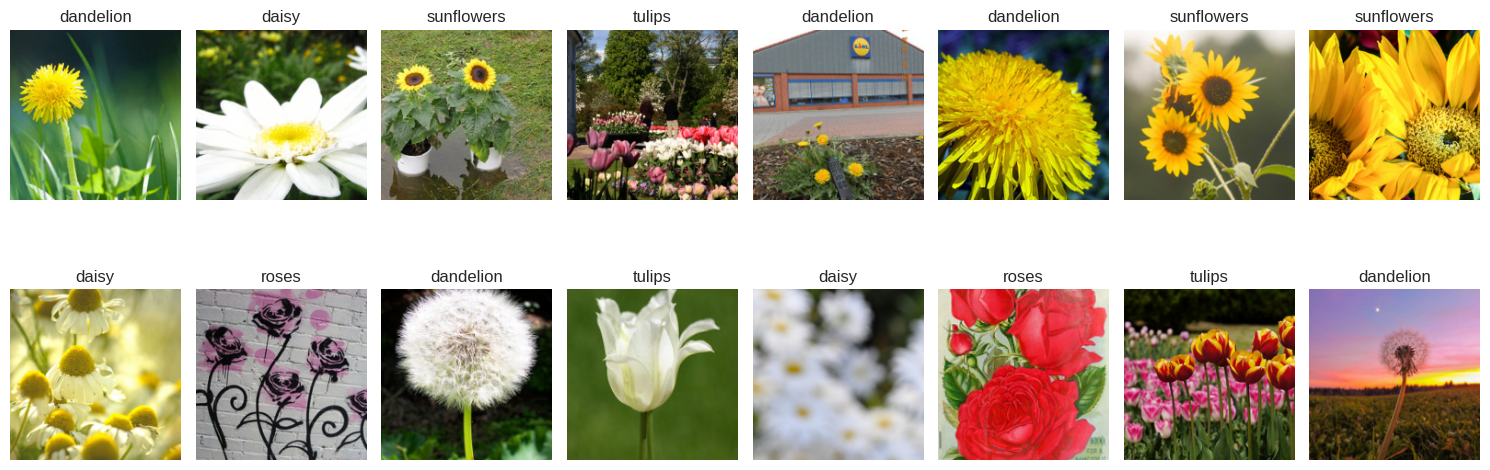

In [22]:
images, labels =next(iter(train_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,6))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)

    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].item()])
fig.tight_layout()

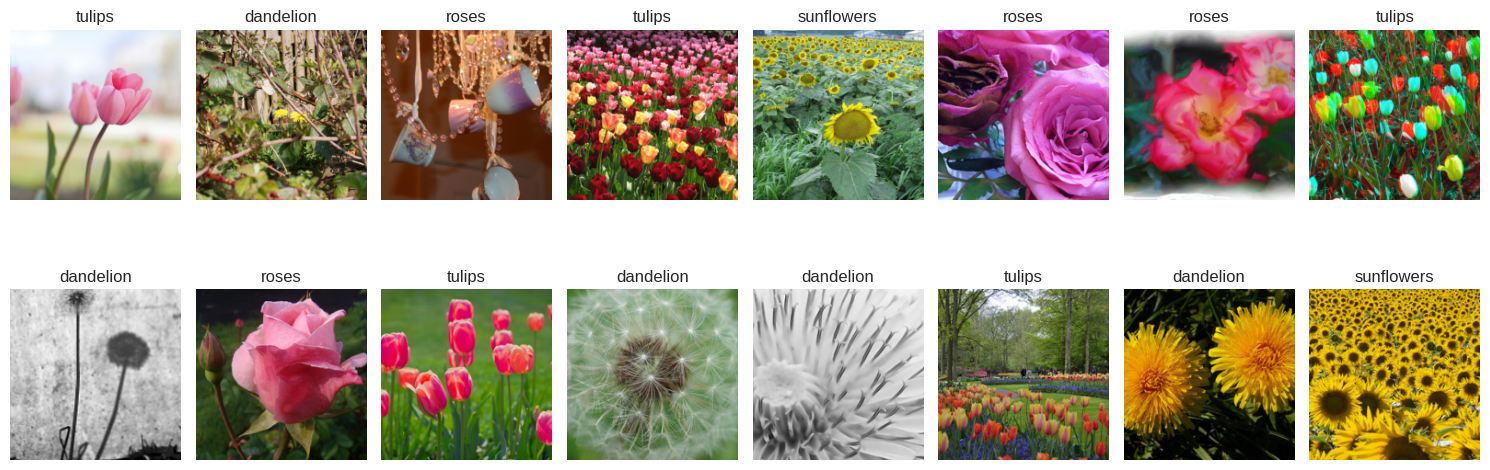

In [23]:
images, labels =next(iter(test_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,6))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)

    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].item()])
fig.tight_layout()

In [48]:
class LeNet(nn.Module):
  def __init__(self, numChannels, classes):

    # call the parent consturctor
    super(LeNet, self).__init__()

    # Dropouts
    dor1 = 0.3
    dor2 = 0.3
    dor3 = 0.4
    dor4 = 0.5
    dor5 = 0.5

    # Define Layers
    #######
    # Set 1
    #######
    out_channels1 = 128
    # Conv => BN => LeakyReLU => Pool => DO
    self.conv1 = nn.Conv2d(in_channels=numChannels,
                           out_channels=out_channels1,
                           kernel_size=(3,3)) # 184 x 184 x 128
    self.bn1 = nn.BatchNorm2d(out_channels1)
    self.actv1 = nn.LeakyReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=(4,4),
                                 stride= (4,4)) # 46 x 46 x 128

    self.dropout1 = nn.Dropout(p=dor1)

    #######
    # Set 2
    #######
    out_channels2 = 128
    # Conv => BN => LeakyReLU => Pool => DO
    self.conv2 = nn.Conv2d(in_channels=out_channels1,
                           out_channels=out_channels2,
                           kernel_size=(3,3)) # 44 x 44 x 128
    self.bn2 = nn.BatchNorm2d(out_channels2)
    self.actv2 = nn.LeakyReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2),
                                 stride= (2,2)) # 22 x 22 x 128

    self.dropout2 = nn.Dropout(p=dor2)

    #######
    # Set 3
    #######
    out_channels3 = 256
    # Conv => BN => LeakyReLU => Pool => DO
    self.conv3 = nn.Conv2d(in_channels=out_channels2,
                           out_channels=out_channels3,
                           kernel_size=(3,3)) # 20 x 20 x 256
    self.bn3 = nn.BatchNorm2d(out_channels3)
    self.actv3 = nn.LeakyReLU()
    self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2),
                                 stride= (2,2)) # 10 x 10 x 256

    self.dropout3 = nn.Dropout(p=dor3)

    #######
    # Set 4
    #######
    out_channels4 = 512
    # Conv => BN => LeakyReLU => Pool => DO
    self.conv4 = nn.Conv2d(in_channels=out_channels3,
                           out_channels=out_channels4,
                           kernel_size=(3,3)) # 8 x 8 x 512
    self.bn4 = nn.BatchNorm2d(out_channels4)
    self.actv4 = nn.LeakyReLU()
    self.maxpool4 = nn.MaxPool2d(kernel_size=(2,2),
                                 stride= (2,2)) # 4 x 4 x 512

    self.dropout4 = nn.Dropout(p=dor4)

    #######
    # Head
    #######
    out_channels5 = 1024
    # Linear => BN => LeakyReLU => Pool => DO
    self.fc1 = nn.Linear(in_features= 4 * 4 * out_channels4,
                         out_features= out_channels5) # 1024

    self.bn5 = nn.BatchNorm1d(out_channels5)
    self.actv5 = nn.LeakyReLU()

    self.dropout5 = nn.Dropout(p=dor5)

    #######
    # Final Output Layer
    #######
    self.fc2 = nn.Linear(in_features= out_channels5,
                         out_features= classes) # 5

    self.logSoftmax = nn.LogSoftmax(dim = 1)

  def forward(self, x):
    # Pass through 1
    x = self.dropout1(self.maxpool1(self.actv1(self.bn1(self.conv1(x)))))

    # Pass through 2
    x = self.dropout2(self.maxpool2(self.actv2(self.bn2(self.conv2(x)))))

    # Pass through 3
    x = self.dropout3(self.maxpool3(self.actv3(self.bn3(self.conv3(x)))))

    # Pass through 4
    x = self.dropout4(self.maxpool4(self.actv4(self.bn4(self.conv4(x)))))

    # Flatten
    x = torch.flatten(x, 1) # flattening the layer

    # Pass through 5
    x = self.dropout5(self.actv5(self.bn5(self.fc1(x))))

    # Output
    x = self.fc2(x)
    return self.logSoftmax(x)


In [49]:
num_channels = 3
model = LeNet(num_channels, numClasses)


In [50]:
model = model.to(device)

In [51]:
summary(model, (num_channels, IMG_HEIGHT, IMG_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 184, 184]           3,584
       BatchNorm2d-2        [-1, 128, 184, 184]             256
         LeakyReLU-3        [-1, 128, 184, 184]               0
         MaxPool2d-4          [-1, 128, 46, 46]               0
           Dropout-5          [-1, 128, 46, 46]               0
            Conv2d-6          [-1, 128, 44, 44]         147,584
       BatchNorm2d-7          [-1, 128, 44, 44]             256
         LeakyReLU-8          [-1, 128, 44, 44]               0
         MaxPool2d-9          [-1, 128, 22, 22]               0
          Dropout-10          [-1, 128, 22, 22]               0
           Conv2d-11          [-1, 256, 20, 20]         295,168
      BatchNorm2d-12          [-1, 256, 20, 20]             512
        LeakyReLU-13          [-1, 256, 20, 20]               0
        MaxPool2d-14          [-1, 256,

In [55]:
# Initialize our optimizer and loss
optimizer = torch.optim.Adam(model.parameters(),
                              lr = ALPHA)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          factor = LR_FACTOR,
                                                          patience = LR_PATIENCE,
                                                          min_lr = 1e-5)
# Initializer a dictionary to store training
H ={
    'Epoch': [],
    'Train Loss' : [],
    'Test Loss' : [],
    'Train Acc' : [],
    'Test Acc' : [],
    'Alpha' : [],
    'Patience' : []
}
print('Done')

Done


In [ ]:
minLoss = float('inf')

savePath = os.path.join('/content/models/flower_photos_torch',"flowers.pth")
for epoch in range(EPOCHS):
  epochStart = time.time()
  train_loss= 0.0
  train_acc = 0.0
  for i,data in enumerate(train_dataloader):
    model.train()
    inputs,labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)

    preds = torch.argmax(outputs, dim=1)
    batch_loss = loss_fn(outputs, labels)
    batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

    batch_loss.backward()
    optimizer.step()

    train_loss += batch_loss.item()*inputs.size(0)
    train_acc += batch_acc.item()*inputs.size(0)

  train_loss = train_loss/len(train_dataset)
  train_acc = train_acc/len(train_dataset)

  H['Train Loss'].append(train_loss)
  H['Train Acc'].append(train_acc)

  test_loss= 0.0
  test_acc = 0.0

  with torch.no_grad():
    model.eval()
    for data in test_dataloader:
      inputs,labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      preds = torch.argmax(outputs, dim=1)

      batch_loss = loss_fn(outputs, labels)
      batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

      test_loss += batch_loss.item()*inputs.size(0)
      test_acc += batch_acc.item()*inputs.size(0)

  test_loss = test_loss/len(test_dataset)
  test_acc = test_acc/len(test_dataset)

  H['Test Loss'].append(test_loss)
  H['Test Acc'].append(test_acc)
  H['Epoch'].append(epoch)

  lr_scheduler.step(test_loss)

  if test_loss < minLoss:
    minLoss = test_loss
    counter = 0

    torch.save({'epoch': epoch+1,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict,
                'loss':loss_fn,}, savePath)
  else:
    counter += 1

  if counter > PATIENCE:
    break

  curr_alpha = lr_scheduler.get_last_lr()[0]
  H['Alpha'].append(curr_alpha)
  H['Patience'].append(counter)

  if epoch % 10 == 0:
    print(f'Epoch:{epoch:3d}/{EPOCHS:3d}',end=' ')
    print(f'Loss:{train_loss:.6f}/{test_loss:.6f}, Accuracy: {train_acc:.4f}/{test_acc:.4f}',end=' ')
    print(f'Alpha:{curr_alpha:.6f}, ES:{counter:2d}',end=' ')
    print(f'Epoch time:{time.time()-epochStart:.2f}Sec')

Epoch:  0/2001 Loss:1.091549/1.087029, Accuracy: 0.5700/0.5647 Alpha:0.001000, ES: 0 Epoch time:27.05Sec
